In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import pickle
from cautious_extrapolation.data_paths import DATA_PATHS 
from cautious_extrapolation.utils import get_imagenet_features, kl_divergence_gaussian
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from wilds import get_dataset

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = get_dataset(dataset="poverty", download=True, root_dir=DATA_PATHS["nfs"]["poverty"])

In [4]:
features_dict= {}
val_data = dataset.get_subset(
    "id_val")

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True)

train_features = get_imagenet_features(val_loader, poverty=True)
features_dict["train"] = train_features

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
test_countries = ['benin', 'burkina_faso', 'guinea', 'sierra_leone', 'tanzania', 'angola', 'cote_d_ivoire', 'ethiopia', 'mali', 'rwanda']

for country in test_countries:
    print(country)
    country_metadata_idx = dataset._metadata_map["country"].index(country)
    country_idxs = np.where(dataset._metadata_array[:, 2] == country_metadata_idx)
    country_data = torch.utils.data.Subset(dataset, country_idxs[0])
    country_loader = torch.utils.data.DataLoader(
        country_data,
        batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)
    features_dict[country] = get_imagenet_features(country_loader, poverty=True)

benin
burkina_faso
guinea
sierra_leone
tanzania
angola
cote_d_ivoire
ethiopia
mali
rwanda


In [46]:
dataset._y_array.shape

torch.Size([19669, 1])

In [5]:
ood_scores_all = [0.5]

for country in test_countries:
    print(country)
    cutoff = min(len(features_dict[country]), len(features_dict["train"]))
    ood_features = features_dict[country][:cutoff]
    val_features = features_dict["train"][:cutoff]
    X = np.concatenate((val_features, ood_features), axis=0)
    y = np.concatenate((np.ones(cutoff), np.zeros(cutoff)), axis=0)
    idxs = np.random.permutation(2*cutoff)
    X = X[idxs]
    y = y[idxs]

    scores = []
    for _ in range(10):
        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=20, alpha=15))
        clf.fit(X[int(0.2*cutoff):], y[int(0.2*cutoff):])
        score = clf.score(X[:int(0.2*len(ood_features))], y[:int(0.2*len(ood_features))])
        scores.append(score)
    ood_scores_all.append(np.mean(scores))

benin
burkina_faso


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


guinea


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


sierra_leone


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


tanzania
angola
cote_d_ivoire


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


ethiopia
mali
rwanda


In [29]:
dir_path = os.path.dirname(os.path.abspath("__file__"))

run_names = ["t_0.001_seed0_2023_06_01_14_16_38"]
dist_from_f_starts_all = []
for run_name in run_names:
    with open(os.path.join(dir_path, "data", run_name, "outputs.pkl"), 'rb') as f:
        data = pickle.load(f)
    

    dist_from_f_starts = []
    for country in ["train"]+test_countries:
        print(country)
        dist_from_f_start = data[country][:, 1].mean()#np.median(kl_divergence_gaussian(data[country][:, 0], data[country][:, 1], 0.1118*np.ones(len(data[country])), 0.9*np.ones(len(data[country])))) #np.median((data[country][:, 1]-0.8)**2)
        print(dist_from_f_start)
        dist_from_f_starts.append(dist_from_f_start)
    dist_from_f_starts_all.append(dist_from_f_starts)


dist_from_f_starts_all = np.array(dist_from_f_starts_all)

In [51]:
run_name = "0.001_seed0_2023_05_31_15_45_14"
with open(os.path.join(dir_path, "data", run_name, "outputs.pkl"), 'rb') as f:
    data = pickle.load(f)

mses = []
stds = []
for country in ["train"]+test_countries:
    print(country)
    mse = data[country][:, 2].mean()#np.median(kl_divergence_gaussian(data[country][:, 0], data[country][:, 1], 0.1118*np.ones(len(data[country])), 0.9*np.ones(len(data[country])))) #np.median((data[country][:, 1]-0.8)**2)
    mses.append(mse)
    print(mse)

    # std = np.mean(np.clip(data[country][:, 1], 0, 1.6))
    std = np.mean((data[country][:, 1]-0.8)**2)
    stds.append(std)

train
0.1798706088267741
benin
0.31011544802487606
burkina_faso
0.1558896886809457
guinea
0.18431767412442962
sierra_leone
0.15521666881541718
tanzania
0.1593853900013201
angola
0.3594124954591409
cote_d_ivoire
0.2488595230171079
ethiopia
0.30097834605452317
mali
0.14347718192824094
rwanda
0.16809530096495698


(array([ 22., 109., 192., 287., 190., 121.,  56.,  17.,   5.,   1.]),
 array([0.05072781, 0.14063079, 0.23053378, 0.32043676, 0.41033974,
        0.50024272, 0.59014571, 0.68004869, 0.76995167, 0.85985465,
        0.94975764]),
 <BarContainer object of 10 artists>)

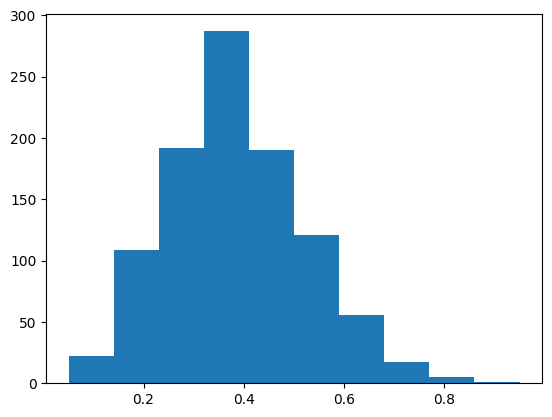

In [46]:
plt.hist(data["train"][:, 1])

In [47]:
np.sqrt(np.e**1)

1.6487212707001282

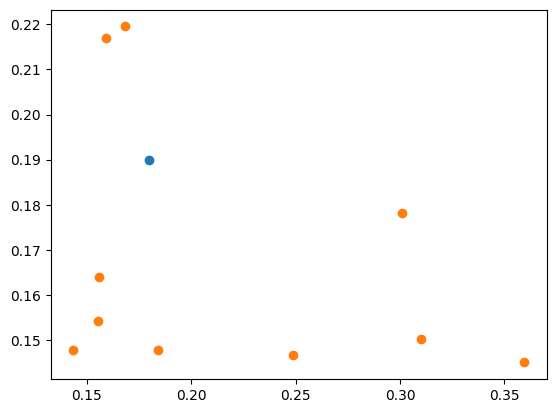

In [52]:
plt.scatter(mses[0], stds[0])
plt.scatter(np.array(mses)[1:], np.array(stds)[1:])

In [32]:
ood_scores_all

[0.5,
 0.7228187919463087,
 0.8146496815286625,
 0.6466666666666667,
 0.7954022988505747,
 0.5325,
 0.6128654970760234,
 0.6779411764705882,
 0.631,
 0.7398305084745762,
 0.6979591836734693]

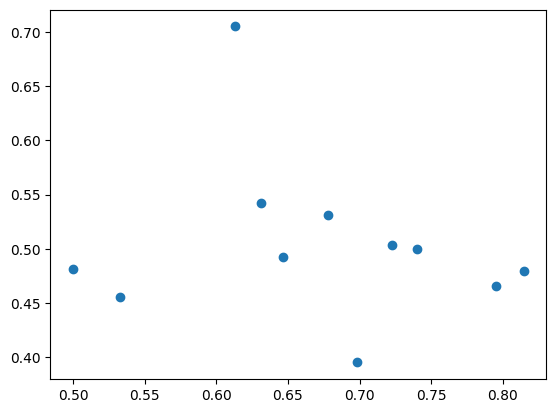

In [30]:
plt.scatter(ood_scores_all, dist_from_f_starts_all[0])

In [15]:
criterion = nn.GaussianNLLLoss().cuda()

In [16]:
loss_sum = 0
total = 0
for input, target, meta_data in val_loader:
    loss = criterion(0.1118*torch.ones(len(target)), target, 0.9*torch.ones(len(target)))
    loss_sum += loss.item()*len(target)
    total += len(target)


In [17]:
loss_sum/total

0.31662358832359316

In [ ]:
dir_path = os.path.dirname(os.path.abspath("__file__"))

run_names = ["0.001_seed0_2023_05_31_15_45_14"]
dist_from_f_starts_all = []
for run_name in run_names:
    with open(os.path.join(dir_path, "data", run_name, "outputs.pkl"), 'rb') as f:
        data = pickle.load(f)
    

    dist_from_f_starts = []
    for country in ["train"]+test_countries:
        dist_from_f_start = np.median(kl_divergence_gaussian(data[country][:, 0], data[country][:, 1], 0.1118*np.ones(len(data[country])), 0.9*np.ones(len(data[country])))) #np.median((data[country][:, 1]-0.8)**2)
        dist_from_f_starts.append(dist_from_f_start)
    dist_from_f_starts_all.append(dist_from_f_starts)


dist_from_f_starts_all = np.array(dist_from_f_starts_all)

In [10]:
dir_path = os.path.dirname(os.path.abspath("__file__"))

with open(os.path.join(dir_path, "data", "0.001_seed0_2023_05_31_15_45_14", "outputs.pkl"), 'rb') as f:
    data = pickle.load(f)

In [39]:
np.median(data["train"][:, 1])

0.4503553807735443

In [37]:
for country in test_countries:
    print(country)
    print(data[country][:, 1].mean())

benin
0.5032186087910036
burkina_faso
0.47942170625403807
guinea
0.4922764061888059
sierra_leone
0.46566211581230166
tanzania
0.4553430911933161
angola
0.705025032877225
cote_d_ivoire
0.5314187952849871
ethiopia
0.5419506354433893
mali
0.5001147318189427
rwanda
0.39512671669566535


In [8]:
for country in test_countries:
    print(country)
    print(np.median(data[country][:, 1]))

benin


NameError: name 'data' is not defined

In [11]:
pred_means = []
for country in ["train"]+test_countries:
    print(country)
    print(np.mean(data[country][:, 0]))
    pred_means.append(np.mean(data[country][:, 0]))

train
0.11839220153726637
benin
0.3082198378862189
burkina_faso
0.0013388026746506926
guinea
0.04667081657176216
sierra_leone
-0.11856664704779783
tanzania
0.04692171866902678
angola
0.17678879958452187
cote_d_ivoire
0.4303956879220925
ethiopia
0.1533701003209843
mali
0.164778461894494
rwanda
-0.19911444962319985


In [6]:
test_countries = ['benin', 'burkina_faso', 'guinea', 'sierra_leone', 'tanzania', 'angola', 'cote_d_ivoire', 'ethiopia', 'mali', 'rwanda']
actual_means = [0.1118]
for country in test_countries:
    print(country)
    country_metadata_idx = dataset._metadata_map["country"].index(country)
    country_idxs = np.where(dataset._metadata_array[:, 2] == country_metadata_idx)
    country_data = torch.utils.data.Subset(dataset, country_idxs[0])
    print(dataset._y_array[country_idxs[0]].mean().item())
    actual_means.append(dataset._y_array[country_idxs[0]].mean().item())
    # plt.scatter(dataset._y_array[country_idxs[0]], data[country][:, 0], alpha=0.05)
# plt.plot([-0.2, 0.5], [-0.2, 0.5])

benin
0.20055291056632996
burkina_faso
-0.1113099455833435
guinea
0.10108967870473862
sierra_leone
-0.1597224920988083
tanzania
-0.11717523634433746
angola
0.23051121830940247
cote_d_ivoire
0.4777851700782776
ethiopia
-0.3384188711643219
mali
0.28399911522865295
rwanda
-0.3437039256095886


ValueError: x and y must be the same size

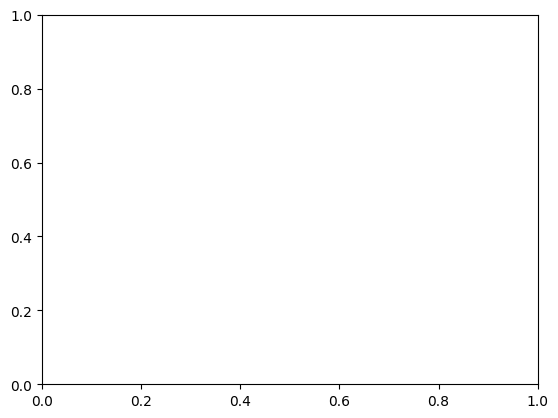

: 

In [54]:
val_idxs = np.where(dataset._metadata_array[:, 1] == 0)
plt.scatter(dataset._y_array[val_idxs[0]], data["train"][:, 0], alpha=0.05)

Text(0.5, 1.0, 'Poverty')

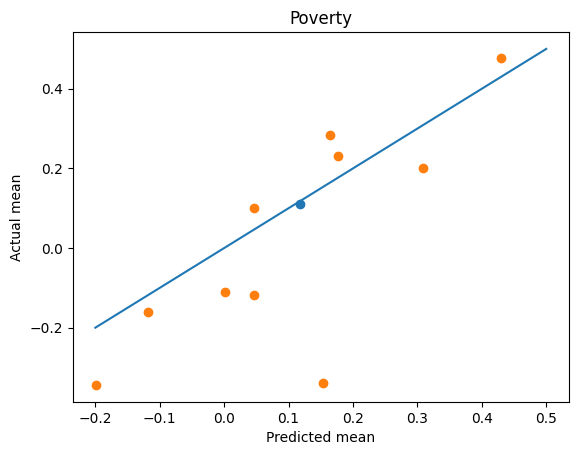

In [16]:
plt.scatter([pred_means[0]], [actual_means[0]])
plt.scatter(pred_means[1:], actual_means[1:])
plt.plot([-0.2, 0.5], [-0.2, 0.5])
plt.xlabel("Predicted mean")
plt.ylabel("Actual mean")
plt.title("Poverty")

In [15]:
np.array(pred_means[1:]).mean()

0.10108031288527537